## Импорт и загрузка данных

In [53]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans, DBSCAN, AgglomerativeClustering
from sklearn.metrics import adjusted_rand_score, normalized_mutual_info_score
import matplotlib.pyplot as plt
import seaborn as sns

# Загрузка данных
train = pd.read_csv("train.csv")
test = pd.read_csv("test.csv")

# Удаление целевой переменной из обучающего набора
train_data = train.drop(columns=["SalePrice"])


## Предобработка данных

In [54]:
# Соединение train и test для единообразной обработки
combined = pd.concat([train_data, test], ignore_index=True)

# Обработка пропущенных значений
combined.fillna(combined.mean(numeric_only=True), inplace=True)

# Преобразование категориальных данных
categorical_cols = combined.select_dtypes(include=["object"]).columns
numeric_cols = combined.select_dtypes(include=[np.number]).columns

# Применение OneHotEncoder для категориальных признаков
encoder = OneHotEncoder(sparse_output=False, handle_unknown='ignore')  # Исправлено: sparse_output вместо sparse
encoded_data = encoder.fit_transform(combined[categorical_cols])

# Объединение числовых и закодированных категориальных признаков
combined_processed = np.hstack([combined[numeric_cols].values, encoded_data])

# Нормализация данных
scaler = StandardScaler()
scaled_data = scaler.fit_transform(combined_processed)

## Кластеризация

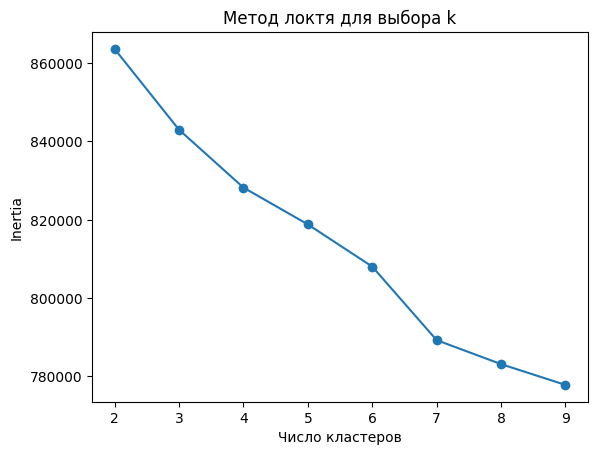

In [55]:
# KMeans
# Оптимальное число кластеров через метод "локтя"
inertia = []
range_n_clusters = range(2, 10)
for n_clusters in range_n_clusters:
    kmeans = KMeans(n_clusters=n_clusters, random_state=42)
    kmeans.fit(scaled_data)
    inertia.append(kmeans.inertia_)

# Построение графика "локтя"
plt.plot(range_n_clusters, inertia, marker='o')
plt.xlabel('Число кластеров')
plt.ylabel('Inertia')
plt.title('Метод локтя для выбора k')
plt.show()

# Применение KMeans
optimal_k = 4  # пример значения
kmeans = KMeans(n_clusters=optimal_k, random_state=42)
kmeans_labels = kmeans.fit_predict(scaled_data)

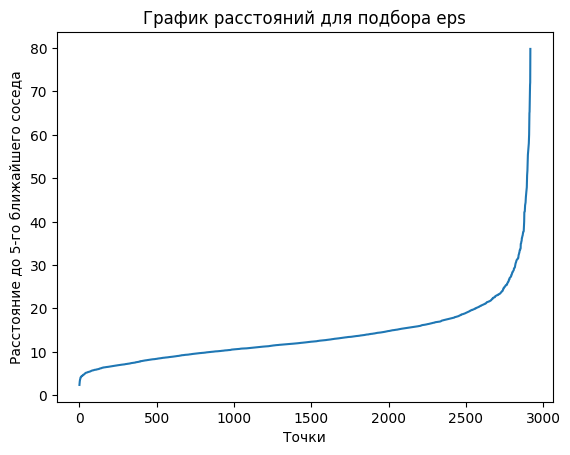

In [56]:
# DBSCAN
# Подбор параметров eps с помощью графика расстояний до k-го ближайшего соседа
from sklearn.neighbors import NearestNeighbors

neighbors = NearestNeighbors(n_neighbors=5)
neighbors_fit = neighbors.fit(scaled_data)
distances, indices = neighbors_fit.kneighbors(scaled_data)

# Сортировка расстояний
distances = np.sort(distances[:, 4], axis=0)

# Построение графика
plt.plot(distances)
plt.xlabel('Точки')
plt.ylabel('Расстояние до 5-го ближайшего соседа')
plt.title('График расстояний для подбора eps')
plt.show()

# Применение DBSCAN с подобранными параметрами
eps = 3.0  # Пример значения, найденного на графике
min_samples = 5
dbscan = DBSCAN(eps=eps, min_samples=min_samples)
dbscan_labels = dbscan.fit_predict(scaled_data)

In [57]:
# Agglomerative Clustering
agglo = AgglomerativeClustering(n_clusters=optimal_k)
agglo_labels = agglo.fit_predict(scaled_data)

## Анализ результатов

KMeans: (0.0020671296723048013, np.float64(0.2088191253937265))
DBSCAN: (-3.6876015325082875e-05, np.float64(0.003554273023763606))
Agglomerative: (0.0019062528998947327, np.float64(0.19922994653303827))


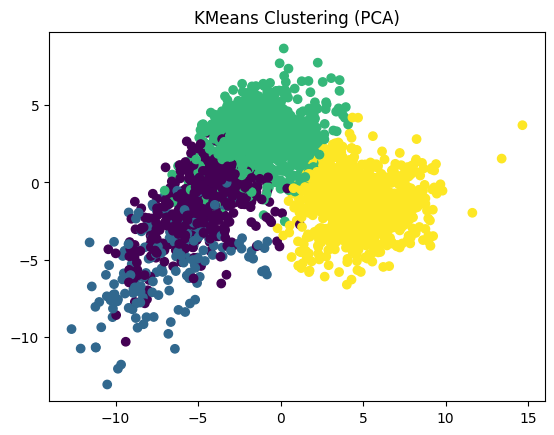

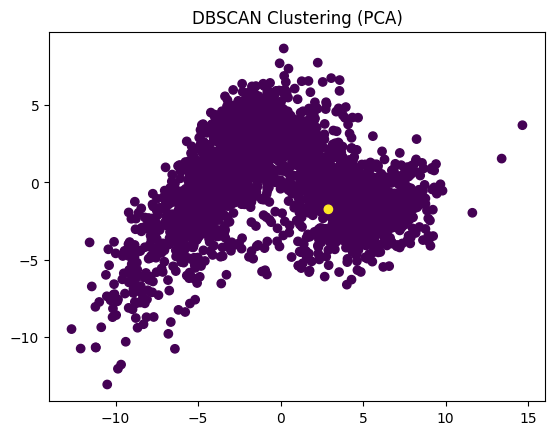

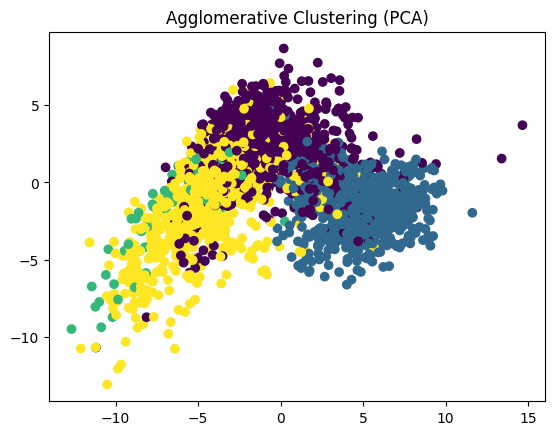

In [58]:
# Истинные метки (только для обучающего набора)
true_labels = train["SalePrice"]

# Метрики качества
def evaluate_clustering(true_labels, cluster_labels):
    ari = adjusted_rand_score(true_labels, cluster_labels)
    nmi = normalized_mutual_info_score(true_labels, cluster_labels)
    return ari, nmi

# Оценка для каждого метода
print("KMeans:", evaluate_clustering(true_labels, kmeans_labels[:len(train)]))
print("DBSCAN:", evaluate_clustering(true_labels, dbscan_labels[:len(train)]))
print("Agglomerative:", evaluate_clustering(true_labels, agglo_labels[:len(train)]))

# Визуализация кластеров с использованием PCA
pca = PCA(n_components=2)
pca_result = pca.fit_transform(scaled_data)

# Визуализация для KMeans
plt.scatter(pca_result[:, 0], pca_result[:, 1], c=kmeans_labels, cmap='viridis')
plt.title('KMeans Clustering (PCA)')
plt.show()

# Визуализация для DBSCAN
plt.scatter(pca_result[:, 0], pca_result[:, 1], c=dbscan_labels, cmap='viridis')
plt.title('DBSCAN Clustering (PCA)')
plt.show()

# Визуализация для Agglomerative Clustering
plt.scatter(pca_result[:, 0], pca_result[:, 1], c=agglo_labels, cmap='viridis')
plt.title('Agglomerative Clustering (PCA)')
plt.show()

## Выводы

# Результаты кластеризации

Методы кластеризации были применены для анализа данных, но их результаты оказались неудовлетворительными:

## Низкие значения метрик

- **ARI (Adjusted Rand Index)** и **NMI (Normalized Mutual Information)** для всех методов кластеризации близки к нулю. Это указывает на то, что выделенные кластеры практически не коррелируют с истинными метками (`SalePrice`).

  Например:
  - KMeans: ARI = 0.0021, NMI = 0.2088
  - DBSCAN: ARI = -3.6876e-05, NMI = 0.0036
  - Agglomerative: ARI = 0.0019, NMI = 0.1992

  Такие низкие значения метрик свидетельствуют о том, что кластеризация не смогла выявить значимые закономерности в данных.

## Отсутствие явной кластерной структуры

- Графики PCA показали, что данные не имеют чётко выраженных кластеров. Это подтверждает, что кластеризация не подходит для анализа этих данных.
- DBSCAN, например, выделил много шумовых точек, что говорит о том, что данные не подходят для кластеризации на основе плотности.

## Несоответствие метода и данных

- Кластеризация — это метод обучения без учителя, который ищет группы объектов на основе их сходства. Однако, если данные не имеют естественной кластерной структуры, результаты будут бессмысленными.
- В данном случае целевая переменная `SalePrice` является непрерывной, и кластеризация не подходит для её анализа. Лучше использовать методы регрессии.

## Риск ошибочных выводов

Если делать выводы на основе этих результатов, можно прийти к неверным заключениям. Например:
- Предположить, что данные имеют кластерную структуру, хотя её нет.
- Считать, что выделенные кластеры связаны с целевой переменной, хотя это не так.

# Итоговый вывод

Результаты кластеризации показали, что данные не имеют явной кластерной структуры, а методы кластеризации не подходят для анализа целевой переменной `SalePrice`. Для решения задачи прогнозирования цен на дома рекомендуется перейти к методам регрессии и улучшить предобработку данных. Это позволит получить более осмысленные и полезные результаты.